<a href="https://colab.research.google.com/github/HaroldRen99/22WEcon441/blob/main/22w441b_In_Class_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import an asset price from Yahoo Finance

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout


########################################
####Pick your ticker and time period####
########################################
stock_data = yf.download("BILI", start="1990-01-01", end="2023-02-01")



# Preprocess data
scaled_data = np.array(stock_data["Close"].pct_change().dropna()).reshape(-1,1)


# Split data into training and test sets
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :]

[*********************100%***********************]  1 of 1 completed


# Create your x_train/y_train data so that your RNN uses percentage change data to make a binary forecast where the stock moves up or down the next day, Build an RNN Architecture accordingly

In [ ]:
x_train = []
y_train = []


#############################################################
####Pick your input size and edit to make binary forecast####
#############################################################
input_size = 5
for i in range(input_size, len(train_data)):
    x_train.append(train_data[i-input_size:i, 0])
    y_train.append(train_data[i, 0])
# for binary forcast, here y_train can be defined as: if train_data[i,0] > 0, y_train.append(1) else y_train.append(0)

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

###################################
####Build Your RNN Architecture####
###################################
model = Sequential()
model.add(LSTM(x_train.shape[1], return_sequences=True, input_shape=(x_train.shape[1], 1)))
#Examples
#model.add(LSTM(50, return_sequences=False))
#model.add(Dense(25))




model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=3)

Epoch 1/3
970/970 [==============================] - 6s 5ms/step - loss: 0.0018
Epoch 2/3
970/970 [==============================] - 3s 3ms/step - loss: 0.0018
Epoch 3/3
970/970 [==============================] - 3s 3ms/step - loss: 0.0018


# Test your model and compare insample Accurracy, insample random walk assumption Accuracy, Out of sample Accuracy and out of sample random walk assumption Accuracy using a bar chart

In [ ]:
test_data = scaled_data[training_data_len - input_size:, :]

x_test = []
y_test = np.array(stock_data[["Close"]].pct_change().dropna())[training_data_len:, :]
# y_test = np.array([1 if x  > 0 else 0 for x in y_test])
for i in range(input_size, len(test_data)):
    x_test.append(test_data[i-input_size:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))




predictions = model.predict(x_test)

8/8 [==============================] - 1s 3ms/step


In [ ]:
# IN Random walk model
in_actual = y_train[1:]
in_predict = y_train[:-1]

# OOS Random walk model
oos_actual = y_test[1:]
oos_predict = y_test[:-1]

In [ ]:
in_predict = np.array([1 if x > 0 else 0 for x in in_predict])
oos_predict = np.array([1 if x > 0 else 0 for x in oos_predict])
in_actual = np.array([1 if x > 0 else 0 for x in in_actual])
oos_actual = np.array([1 if x > 0 else 0 for x in oos_actual])

In [ ]:
from sklearn.metrics import accuracy_score
in_accuracy = accuracy_score(in_actual,in_predict)
oos_accuracy = accuracy_score(oos_actual,oos_predict)

<BarContainer object of 2 artists>

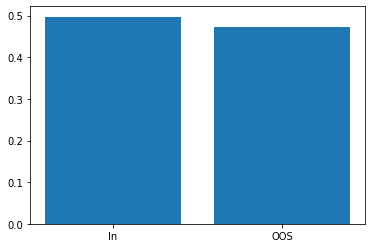

In [ ]:
from matplotlib import pyplot as plt
plt.bar(["In","OOS"],[in_accuracy, oos_accuracy])

# Plot in and out of sample accuracy

8/8 [==============================] - 0s 3ms/step


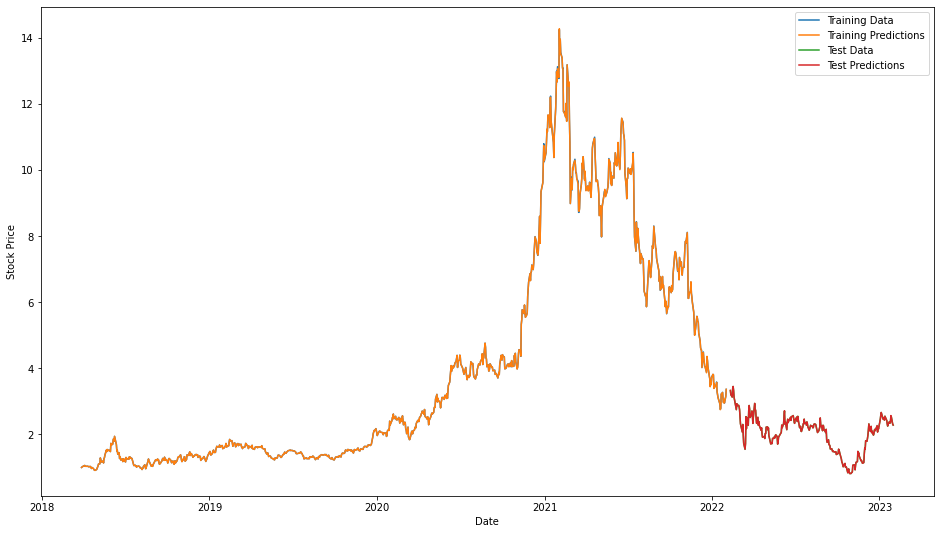

In [ ]:
import matplotlib.pyplot as plt

# Make predictions on full dataset

test_predict = model.predict(x_test)
test_predictions = (test_predict+1).reshape(-1,len(y_test)) * np.cumprod(y_test+1)

train_predict = model.predict(x_train)
train_predictions = (train_predict+1).reshape(-1,len(y_train)) * np.cumprod(y_train+1)


plt.figure(figsize = (16,9))
plt.plot(stock_data[:training_data_len- input_size].index, np.cumprod(y_train+1), label="Training Data")
plt.plot(stock_data[:training_data_len- input_size].index, train_predictions[0], label="Training Predictions")
end_val = np.cumprod(y_train+1)[-1]
test_predict = model.predict(x_test)
test_predictions = (test_predict+1).reshape(-1, len(y_test)) * (np.cumprod((y_test+1))*end_val)
plt.plot(stock_data[training_data_len+1:].index, np.cumprod((y_test+1))*end_val,label="Test Data")
plt.plot(stock_data[training_data_len+1:].index, test_predictions[0], label="Test Predictions")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

# Write an observation/conclusion about the graphs from Q4 and Q3

From graphs in Q3, the difference between In and Out of sample accuracy is not siginificant, so we can say that there is no problem of overfitting. With the accuracy close to 0.5, we can say that the prediction is moderately precise.

From graphs in Q4, we can see that the predicition line is closely overlapped with the actual one, both in and out of sample model. So we can say that the model has a good prediction accuracy.

# Create a parameter for number of lags in your input layer. Do a 3-fold CV to test three different time lags. i.e. Tested using 5,10,20 days of previous price data to forecast

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor

# Define the Keras model
###Edit here to create your optimizer
def create_model(units=5):
    model = Sequential()
    model.add(LSTM(units, input_shape=(5, 1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return(model)

# Wrap the Keras model in a scikit-learn compatible estimator
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the hyperparameters to search over

param_grid = {'batch_size': [10, 20, 100],
              'epochs': [10, 100],
              'units':[5,10,20]}

# Perform the grid search over the hyperparameters

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)

# Print the results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

<ipython-input-12-a73dba6e536f>:15: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best: -0.015443 using {'batch_size': 100, 'epochs': 100, 'units': 10}
